In [1]:
import pandas as pd
import sklearn
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv('data/data.csv')
cpi = pd.read_csv('data/cpi.csv')

In [3]:
# Price adjustment for inflation
df['BCreatedDateAEST'] = pd.to_datetime(df['BCreatedDateAEST']);
df['Quarter'] = df['BCreatedDateAEST'].dt.to_period('Q');
cpi['Quarter'] = pd.to_datetime(cpi['Quarter']).dt.to_period('Q');
base_cpi = cpi['CPI'].iloc[-1]

/tmp/ipykernel_65307/1965790900.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['BCreatedDateAEST'] = pd.to_datetime(df['BCreatedDateAEST']);
/tmp/ipykernel_65307/1965790900.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cpi['Quarter'] = pd.to_datetime(cpi['Quarter']).dt.to_period('Q');


In [4]:
merged_df = df.merge(cpi, on='Quarter');
#Round to two decimal places to remain consistent with the existing data
merged_df['adjusted_price'] = round(merged_df['PriceIncGSTRaw'] * (base_cpi / merged_df['CPI']), 2)

In [5]:
original_status_column = 'BStatusAfterSubmitted' 
immediately_approved_status = '33. Approved' 
glitch_status = '12. Submitted' 

merged_df_cleaned = merged_df[merged_df[original_status_column] != glitch_status].copy()

merged_df_cleaned['IsApproved'] = (merged_df_cleaned[original_status_column] == immediately_approved_status).astype(int)

target_column = 'IsApproved'

feature_columns = [
    'TaskName',
    'VYear',
    'VMake',
    'VMakeModel',
    'BShopRegionName',
    'BTicketType',
    'BShopState',
    'adjusted_price' 
]

In [6]:
#Splitting data
train_X = merged_df_cleaned.loc[1:201, feature_columns]
train_Y = merged_df_cleaned.loc[1:201, target_column]

val_X = merged_df_cleaned.loc[201:226, feature_columns]
val_Y = merged_df_cleaned.loc[201:226, target_column]

test_X = merged_df_cleaned.loc[226:251, feature_columns]
test_Y = merged_df_cleaned.loc[226:251, target_column]

In [7]:
#Binary Encodes Task name, VYMM, VMake and Shop region name
binary_encoder = ce.BinaryEncoder(cols=['TaskName', 'VMake', 'VMakeModel', 'BShopRegionName'])
Binary_train_X = binary_encoder.fit_transform(train_X)
Binary_val_X = binary_encoder.transform(val_X)
Binary_test_X = binary_encoder.transform(test_X)
print("After Binary Encoding (train_X columns):", Binary_train_X.columns)

#One Hot Encodes ticket type and shop state
onehot_encoder = ce.OneHotEncoder(cols=['BTicketType', 'BShopState'])
Encoded_train_X = onehot_encoder.fit_transform(Binary_train_X)
Encoded_val_X = onehot_encoder.transform(Binary_val_X)
Encoded_test_X = onehot_encoder.transform(Binary_test_X)
print("After OneHot Encoding (train_X columns):", Encoded_train_X.columns)



After Binary Encoding (train_X columns): Index(['TaskName_0', 'TaskName_1', 'TaskName_2', 'TaskName_3', 'TaskName_4',
       'TaskName_5', 'TaskName_6', 'VYear', 'VMake_0', 'VMake_1', 'VMake_2',
       'VMake_3', 'VMake_4', 'VMakeModel_0', 'VMakeModel_1', 'VMakeModel_2',
       'VMakeModel_3', 'VMakeModel_4', 'VMakeModel_5', 'BShopRegionName_0',
       'BShopRegionName_1', 'BShopRegionName_2', 'BShopRegionName_3',
       'BShopRegionName_4', 'BShopRegionName_5', 'BTicketType', 'BShopState',
       'adjusted_price'],
      dtype='object')
After OneHot Encoding (train_X columns): Index(['TaskName_0', 'TaskName_1', 'TaskName_2', 'TaskName_3', 'TaskName_4',
       'TaskName_5', 'TaskName_6', 'VYear', 'VMake_0', 'VMake_1', 'VMake_2',
       'VMake_3', 'VMake_4', 'VMakeModel_0', 'VMakeModel_1', 'VMakeModel_2',
       'VMakeModel_3', 'VMakeModel_4', 'VMakeModel_5', 'BShopRegionName_0',
       'BShopRegionName_1', 'BShopRegionName_2', 'BShopRegionName_3',
       'BShopRegionName_4', 'BShopRegi

In [8]:
model = DecisionTreeClassifier(random_state=42)
model.fit(Encoded_train_X, train_Y)
#val_predictions = model.predict(Encoded_val_X)

DecisionTreeClassifier(random_state=42)

In [ ]:
# Confidence score at the moment is its confidence in their prediction being correct
# Currently at 1 because its overfitting and is hence over confident 
def eval_classification_performance(model, train_X, y_train, eval_X, y_eval):
    """
    Evaluates a scikit-learn classification model on training and an evaluation dataset,
    displays confusion matrices, prints a classification report, and shows average confidence.

    Args:
        model: Trained scikit-learn classification model.
        train_X: Training features (pandas DataFrame).
        y_train: Training target (pandas Series).
        eval_X: Evaluation features (pandas DataFrame - typically validation or test).
        y_eval: Evaluation target (pandas Series - typically validation or test).
    """
    print("Evaluating model performance...")

    train_pred_labels = model.predict(train_X)

    eval_pred_labels = model.predict(eval_X)

    eval_pred_proba = model.predict_proba(eval_X)

    eval_confidence_in_prediction = np.max(eval_pred_proba, axis=1)

    train_acc = accuracy_score(y_train, train_pred_labels)
    eval_acc = accuracy_score(y_eval, eval_pred_labels) 

    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Evaluation Accuracy: {eval_acc:.4f}") 

    print(f"Average Confidence in Predicted Class on Evaluation Set: {np.mean(eval_confidence_in_prediction):.4f}")

    fig, axes = plt.subplots(1, 2, figsize=(15, 6)) 

    ConfusionMatrixDisplay.from_predictions(y_train, train_pred_labels, normalize='true', ax=axes[0])
    axes[0].set_title(f"Training Set Performance: Accuracy={train_acc:.2f}")
    axes[0].set_xlabel("Predicted label")
    axes[0].set_ylabel("True label")

    ConfusionMatrixDisplay.from_predictions(y_eval, eval_pred_labels, normalize='true', ax=axes[1])
    axes[1].set_title(f"Evaluation Set Performance: Accuracy={eval_acc:.2f}") 
    axes[1].set_xlabel("Predicted label")
    axes[1].set_ylabel("True label")


    plt.tight_layout()
    plt.show()

    print("\nEvaluation Set Classification Report:") 
    
    print(classification_report(y_eval, eval_pred_labels))



Evaluating model performance...
Training Accuracy: 0.9797
Evaluation Accuracy: 0.4400
Average Confidence in Predicted Class on Evaluation Set: 1.0000


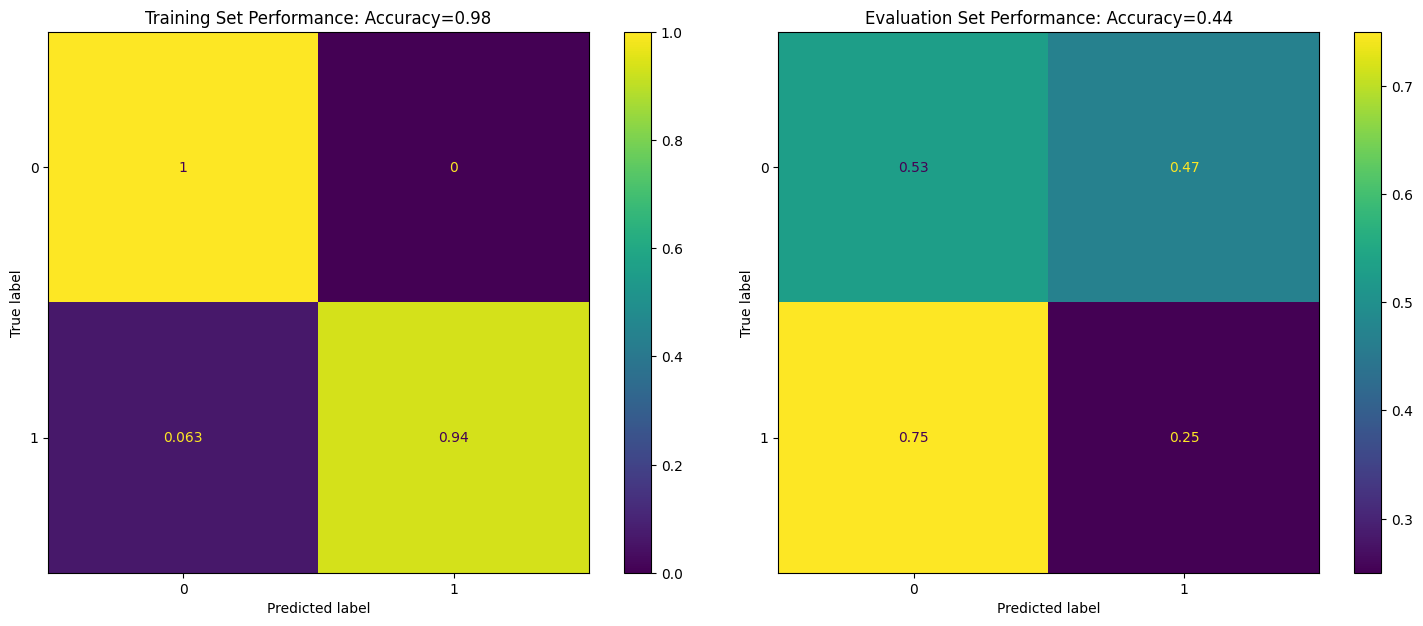


Evaluation Set Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.53      0.56        17
           1       0.20      0.25      0.22         8

    accuracy                           0.44        25
   macro avg       0.40      0.39      0.39        25
weighted avg       0.47      0.44      0.45        25



In [10]:
# For Validation set
eval_classification_performance(model, Encoded_train_X, train_Y, Encoded_val_X, val_Y)

Evaluating model performance...
Training Accuracy: 0.9797
Evaluation Accuracy: 0.5385
Average Confidence in Predicted Class on Evaluation Set: 1.0000


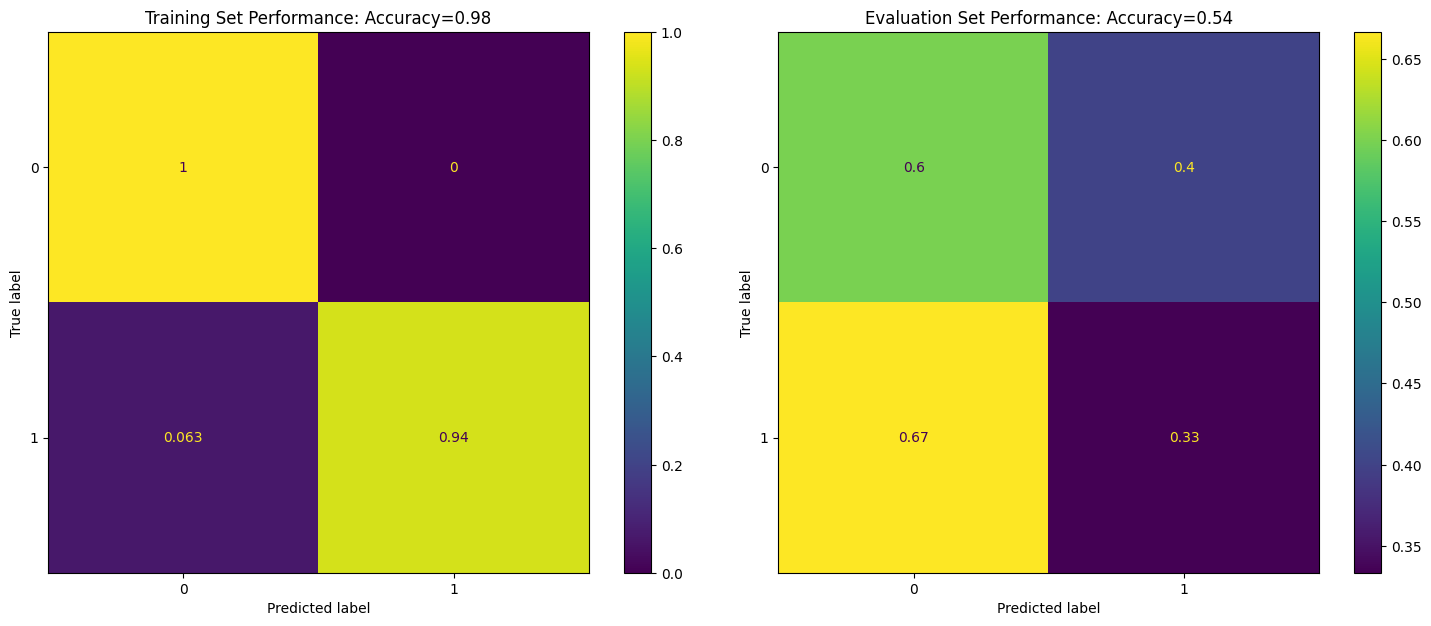


Evaluation Set Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        20
           1       0.20      0.33      0.25         6

    accuracy                           0.54        26
   macro avg       0.47      0.47      0.46        26
weighted avg       0.62      0.54      0.57        26



In [11]:
# For Test set
eval_classification_performance(model, Encoded_train_X, train_Y, Encoded_test_X, test_Y)